![kaggle_housesbanner](https://storage.googleapis.com/kaggle-media/competitions/kaggle/5407/media/housesbanner.png)

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import boxcox1p
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import xgboost as xgb

pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams['figure.figsize'] = (6, 4)

<h1 style="font-size: 1.8em; background-color: #CFB87C; padding: 0.8em">Problem Definition</h1>

This project uses the Ames Housing Dataset available at http://jse.amstat.org/v19n3/decock/AmesHousing.txt, which includes 79 features describing a wide range of characteristics of 2,930 homes in Ames, Iowa, USA, sold during the 2006 - 2010 timeframe.

Given the Ames Housing Data, the objective is to develop a predictive model that can accurately estimate the sale prices of residential properties in Ames, Iowa. This model should be able to generalize well to unseen data and provide insights into the key factors influencing housing prices.

In [2]:
url = 'http://jse.amstat.org/v19n3/decock/AmesHousing.txt'
df = pd.read_csv(url, sep='\t')

<h1 style="font-size: 1.8em; background-color: #CFB87C; padding: 0.8em">Exploratory Data Analysis</h1>

In [3]:
# 2930 Observations, 79 Features (Excluding 'Order' and 'PID') and 1 target variable (SalePrice)
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.000,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.000,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
df.shape

(2930, 82)

### Data Documentation

https://jse.amstat.org/v19n3/decock/DataDocumentation.txt

| Variable | Description |
| --- | --- |
| Order (Discrete) | Observation number |
| PID (Nominal) | Parcel identification number |
| MS SubClass (Nominal) | Identifies the type of dwelling involved in the sale |	
| MS Zoning (Nominal) | Identifies the general zoning classification of the sale |
| Lot Frontage (Continuous) | Linear feet of street connected to property |
| Lot Area (Continuous) | Lot size in square feet |
| Street (Nominal | Type of road access to property |
| Alley (Nominal) | Type of alley access to property |
| Lot Shape (Ordinal) | General shape of property |
| Land Contour (Nominal) | Flatness of the property |		
| Utilities (Ordinal) | Type of utilities availablev
| Lot Config (Nominal) | Lot configuration |
| Land Slope (Ordinal) | Slope of property |
| Neighborhood (Nominal) | Physical locations within Ames city limits (map available) |
| Condition 1 (Nominal) | Proximity to various conditions |
| Condition 2 (Nominal) | Proximity to various conditions (if more than one is present) |
| Bldg Type (Nominal) | Type of dwelling |
| House Style (Nominal) | Style of dwelling |
| Overall Qual (Ordinal) | Rates the overall material and finish of the house |
| Overall Cond (Ordinal) | Rates the overall condition of the house |		
| Year Built (Discrete) | Original construction date |
| Year Remod/Add (Discrete) | Remodel date (same as construction date if no remodeling or additions) |
| Roof Style (Nominal) | Type of roof |
| Roof Matl (Nominal) | Roof material |		
| Exterior 1 (Nominal) | Exterior covering on house |
| Exterior 2 (Nominal) | Exterior covering on house (if more than one material) |
| Mas Vnr Type (Nominal) | Masonry veneer type |
| Mas Vnr Area (Continuous) | Masonry veneer area in square feet |
| Exter Qual (Ordinal) | Evaluates the quality of the material on the exterior | 
| Exter Cond (Ordinal) | Evaluates the present condition of the material on the exterior |
| Foundation (Nominal) | Type of foundation |
| Bsmt Qual (Ordinal) | Evaluates the height of the basement |
| Bsmt Cond (Ordinal) | Evaluates the general condition of the basement |
| Bsmt Exposure	(Ordinal) | Refers to walkout or garden level walls |
| BsmtFin Type 1 (Ordinal) | Rating of basement finished area |		
| BsmtFin SF 1 (Continuous) | Type 1 finished square feet |
| BsmtFinType 2	(Ordinal) | Rating of basement finished area (if multiple types) |
| BsmtFin SF 2 (Continuous) | Type 2 finished square feet |
| Bsmt Unf SF (Continuous) | Unfinished square feet of basement area |
| Total Bsmt SF (Continuous) | Total square feet of basement area |
| Heating (Nominal) | Type of heating |
| HeatingQC (Ordinal) | Heating quality and condition |
| Central Air (Nominal) | Central air conditioning |
| Electrical (Ordinal) | Electrical system |		
| 1st Flr SF (Continuous) | First Floor square feet |
| 2nd Flr SF (Continuous | Second floor square feet |
| Low Qual Fin SF (Continuous) | Low quality finished square feet (all floors) |
| Gr Liv Area (Continuous) | Above grade (ground) living area square feet |
| Bsmt Full Bath (Discrete) | Basement full bathrooms |
| Bsmt Half Bath (Discrete) | Basement half bathrooms |
| Full Bath (Discrete) | Full bathrooms above grade |
| Half Bath (Discrete) | Half baths above grade |
| Bedroom (Discrete) | Bedrooms above grade (does NOT include basement bedrooms) |
| Kitchen (Discrete) | Kitchens above grade |
| KitchenQual (Ordinal) | Kitchen quality |      	
| TotRmsAbvGrd	(Discrete) | Total rooms above grade (does not include bathrooms) |
| Functional (Ordinal) | Home functionality (Assume typical unless deductions are warranted) |
| Fireplaces (Discrete) | Number of fireplaces |
| FireplaceQu (Ordinal) | Fireplace quality |
| Garage Type (Nominal) | Garage location |		
| Garage Yr Blt (Discrete) | Year garage was built |		
| Garage Finish (Ordinal) | Interior finish of the garage |		
| Garage Cars (Discrete) | Size of garage in car capacity |
| Garage Area (Continuous) | Size of garage in square feet |
| Garage Qual (Ordinal) | Garage quality |		
| Garage Cond (Ordinal) | Garage condition |
| Paved Drive (Ordinal) | Paved driveway |
| Wood Deck SF (Continuous) | Wood deck area in square feet |
| Open Porch SF (Continuous) | Open porch area in square feet |
| Enclosed Porch (Continuous) | Enclosed porch area in square feet |
| 3-Ssn Porch (Continuous) | Three season porch area in square feet |
| Screen Porch (Continuous) | Screen porch area in square feet |
| Pool Area (Continuous) | Pool area in square feet |
| Pool QC (Ordinal) | Pool quality |
| Fence (Ordinal) | Fence quality |
| Misc Feature (Nominal) | Miscellaneous feature not covered in other categories |
| Misc Val (Continuous) | $ Value of miscellaneous feature |
| Mo Sold (Discrete) | Month Sold (MM) |
| Yr Sold (Discrete) | Year Sold (YYYY) |
| Sale Type (Nominal) | Type of sale |
| Sale Condition (Nominal) | Condition of sale |
| SalePrice (Continuous) | Sale price $$ |

### Checking for duplicates

In [5]:
n_unique_IDs = len(df['PID'].unique())
n_samples = df.shape[0]
n_duplicates = n_samples - n_unique_IDs
print('There are ' + str(n_duplicates) + ' duplicate IDs for ' + str(n_samples) + ' total observations')

There are 0 duplicate IDs for 2930 total observations


In [3]:
# Drop 'Order': Observation number and 'PID': Parcel identification number
df = df.drop(['Order', 'PID'], axis=1)

### Identifying outliers

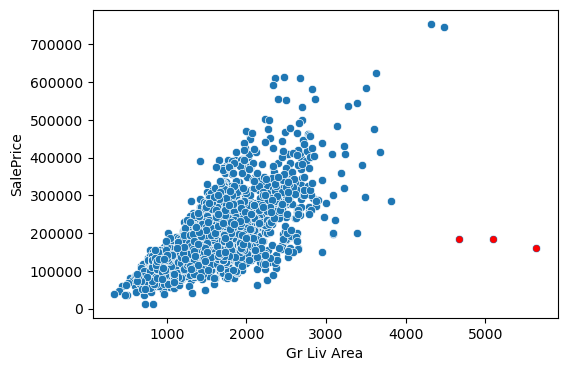

In [7]:
sns.scatterplot(data=df, x='Gr Liv Area', y='SalePrice')
plt.scatter(x=[5642, 5095, 4676], y=[160000, 183850, 184750], color='red', s=15);

In [4]:
# Get indices of the 3 outliers identified in the plot above, then drop them
idx_to_drop = df[(df['Gr Liv Area'] > 4000) & (df['SalePrice'] < 300000)].index.values
df = df.drop(idx_to_drop, axis=0)

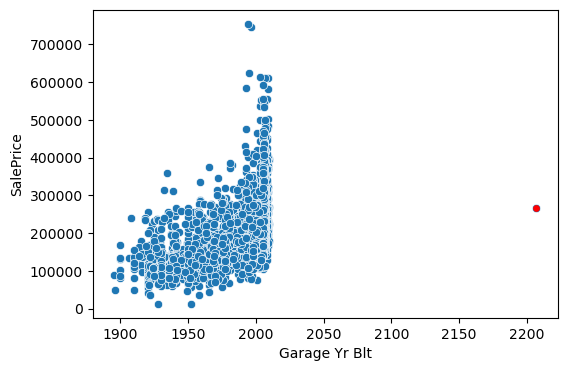

In [9]:
# Garage Yr Blt is 2207, which is an obvious error, and so we will drop this observation
sns.scatterplot(data=df, x='Garage Yr Blt', y='SalePrice')
plt.scatter(x=[2207], y=[267300], color='red', s=15);

In [5]:
idx_to_drop = df[df['Garage Yr Blt'] > 2150].index.values
df = df.drop(idx_to_drop, axis=0)

In [6]:
# Reset index since we removed some rows due to outliers
df = df.reset_index(drop=True)

### Checking the distribution of the target variable

Skewness = 1.7430333247873002


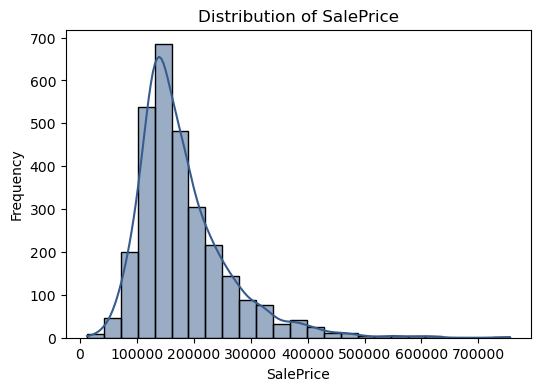

In [12]:
skewness = stats.skew(df['SalePrice'])
print('Skewness =', skewness)
sns.histplot(df['SalePrice'], kde=True, bins=25, color=sns.color_palette("viridis")[1])
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency');

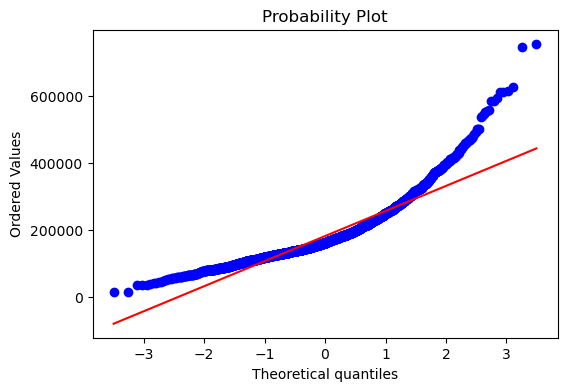

In [13]:
stats.probplot(df['SalePrice'], plot=plt);

Rule of thumb for skewness: 
* skewness absolute value between 0.5 and 1 are considered moderately skewed. 
* if the skewness is less than -1 or greater than 1, the data are highly skewed.

SalePrice distribution is quite skewed, and QQ plot clearly shows that it violates the normality assumption in Linear Regression. We will apply log transformation to make it more normally distributed. 

In [7]:
df['SalePrice'] = np.log(df['SalePrice'])

We will deal with skewness in features that have high correlation with target variable later.

<h1 style="font-size: 1.8em; background-color: #CFB87C; padding: 0.8em">Dealing with missing data</h1>

We will refer to data documentation when deciding what type of missing values imputation is best.

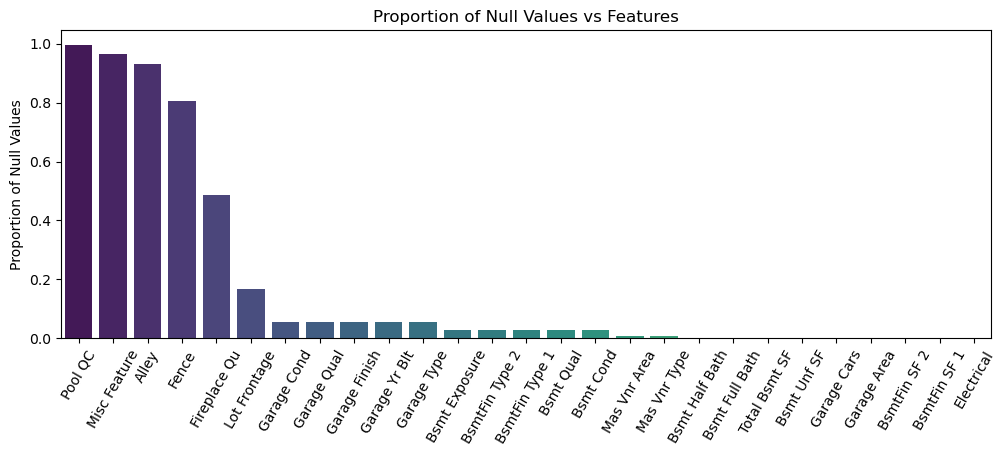

In [15]:
# Calculate number of null values per column
null_counts = df.isnull().sum()

# Filter out columns with zero null values, then sort
null_counts = null_counts[null_counts > 0] / df.shape[0]
null_counts = null_counts.sort_values(ascending=False)
plt.figure(figsize=(12, 4))
sns.barplot(x=null_counts.index, y=null_counts.values, palette='viridis')
plt.xticks(rotation=60)
plt.ylabel('Proportion of Null Values')
plt.title('Proportion of Null Values vs Features');

In [16]:
# Possible missing values
missing_vals = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']

In [17]:
for column in df:
    string_null = np.array([x in missing_vals[2:] for x in df[column]])
    if string_null.sum():
        print(column, ', string null:', string_null.sum(), '  isnull:', df[column].isnull().sum())

Mas Vnr Type , string null: 1752   isnull: 22


In [18]:
df['Mas Vnr Type'].unique()

array(['Stone', 'None', 'BrkFace', nan, 'BrkCmn', 'CBlock'], dtype=object)

We will replace nan with 'None' in 'Mas Vnr Type' since it most is likely means no masonry veneer.

Related to this feature is 'Mas Vnr Area'. We will replace missing values with 0.

In [8]:
df['Mas Vnr Type'] = df['Mas Vnr Type'].fillna('None')
df['Mas Vnr Area'] = df['Mas Vnr Area'].fillna(0)

We will drop 'Pool QC' and 'Misc Feature' since both have too many missing values and thus of little information to our predictive model. 

'Pool Area' and 'Misc Val' are related to 'Pool QC' and 'Misc Feature', and so will also also drop these two features.

In [9]:
df = df.drop(['Pool QC', 'Misc Feature', 'Pool Area', 'Misc Val'], axis=1)

'Alley': NA means No alley access

'Fence': NA means No Fence

'Fireplace Qu': NA means No Fireplace

In [10]:
df['Alley'] = df['Alley'].fillna('None')
df['Fence'] = df['Fence'].fillna('None')
df['Fireplace Qu'] = df['Fireplace Qu'].fillna('None')

Next, we will impute 'Lot Frontage' missing values with the median Lot Frontage of the neighborhood since it is most likely similar to other houses in its neighborhood.

In [11]:
df["Lot Frontage"] = df.groupby("Neighborhood")["Lot Frontage"].transform(lambda value: value.fillna(value.median()))

In [23]:
# There are still missing values, upon further checking there are 2 neighborhoods with no Lot Frontage information at all.
df["Lot Frontage"].isna().sum()

3

In [73]:
# These 2 neighborhoods does not have Lot Frontage information, will replace na with median value of all Lot Frontage
df[df['Neighborhood'] == 'GrnHill']['Lot Frontage']

2253   NaN
2888   NaN
Name: Lot Frontage, dtype: float64

In [74]:
df[df['Neighborhood'] == 'Landmrk']['Lot Frontage']

2784   NaN
Name: Lot Frontage, dtype: float64

In [12]:
df.loc[[2253, 2888, 2784], 'Lot Frontage'] = df['Lot Frontage'].median()

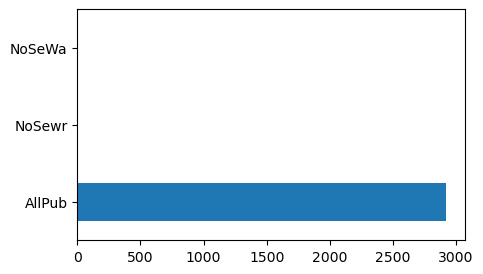

In [27]:
_, ax = plt.subplots(figsize=(5, 3))
df['Utilities'].value_counts().plot.barh(ax=ax);

In [28]:
df[df['Utilities'] == 'NoSeWa']

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Fence,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
955,20,RL,82.500,14375,Pave,None,IR1,Lvl,NoSeWa,CulDSac,...,118,0,0,233,None,1,2009,COD,Abnorml,11.831


In [13]:
# Since almost all values in 'Utilities' are AllPub, it is of little information in predictive model, we will drop this feature
df = df.drop('Utilities', axis=1)

In [14]:
# Replace missing values with 'None'
for feature in ['Garage Cond', 'Garage Qual', 'Garage Finish', 'Garage Type']:
    df[feature] = df[feature].fillna('None')

Replace missing values with 0 since it is likely means no garage, therefore zero Garage Area and zero Cars in such garage.

In [15]:
for feature in ['Garage Cars', 'Garage Area']:
    df[feature] = df[feature].fillna(0)

In [16]:
# Replace missing value with the min year, since it's likely means no garage and it's not reasonable to fill na with year 0.
df['Garage Yr Blt'] = df['Garage Yr Blt'].fillna(df['Garage Yr Blt'].min())

In [17]:
# Replace missing values with None since it's likely there is no basement
for feature in ['Bsmt Exposure', 'BsmtFin Type 2', 'Bsmt Qual', 'Bsmt Cond', 'BsmtFin Type 1']:
    df[feature] = df[feature].fillna('None')

In [18]:
# Replace missing values with zero for having no basement
for feature in ['Bsmt Full Bath', 'Bsmt Half Bath', 'Total Bsmt SF', 'Bsmt Unf SF',
               'BsmtFin SF 2', 'BsmtFin SF 1']:
    df[feature] = df[feature].fillna(0)

In [19]:
# Replace missing values with its mode
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

In [20]:
# Check if there is any remaining missing values
missing_vals = df.isna().sum()
missing_vals = missing_vals.drop(missing_vals[missing_vals == 0].index)
missing_vals

Series([], dtype: int64)

In [21]:
df.to_csv('df_no_missing.csv', index=False)

In [244]:
df = pd.read_csv('df_no_missing.csv')

### Fix incorrect data type

In [22]:
df['Garage Yr Blt'].dtype

dtype('float64')

In [25]:
df['Garage Yr Blt'] = df['Garage Yr Blt'].astype(int)

<h1 style="font-size: 1.8em; background-color: #CFB87C; padding: 0.8em">Pairwise correlation of columns and Variance Inflation Factor</h1>

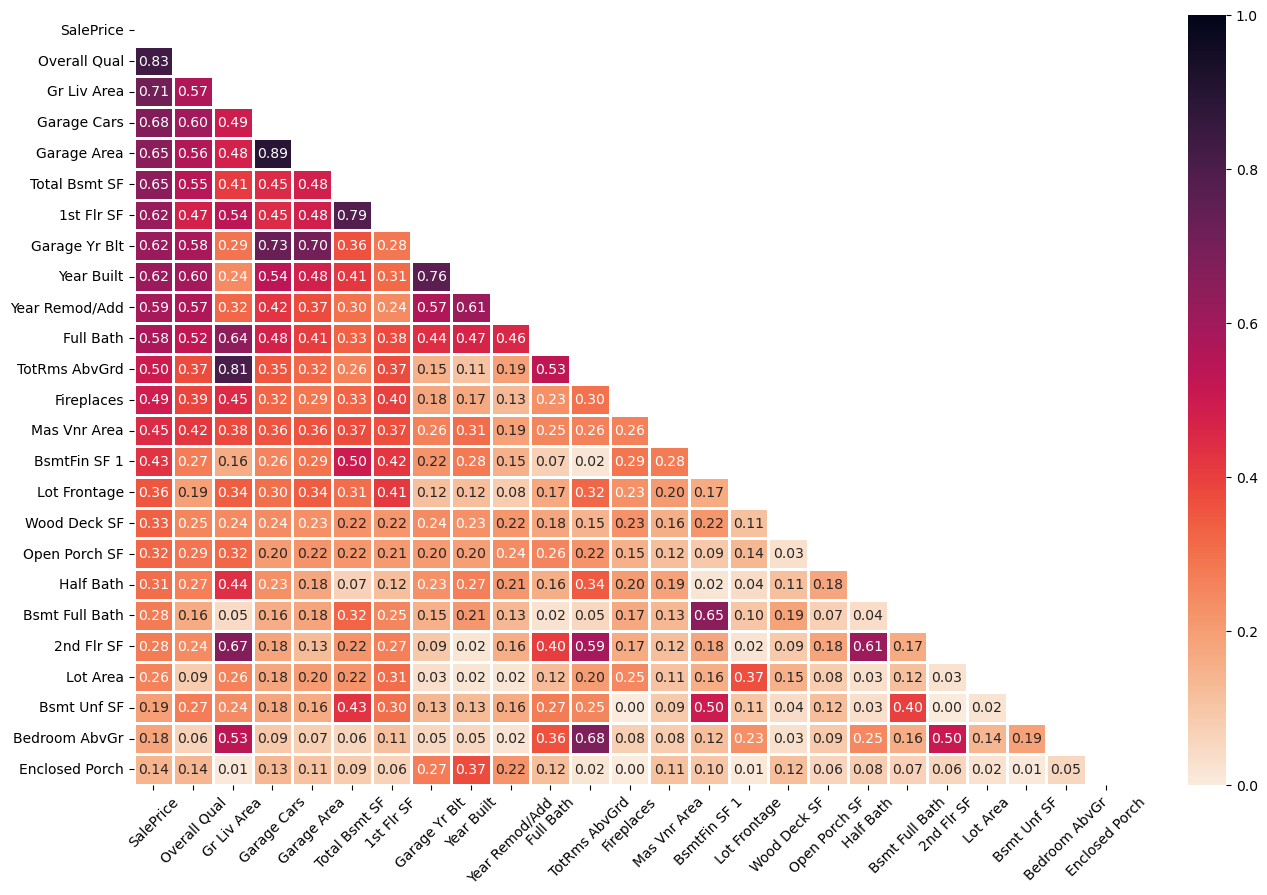

In [27]:
# Compute pairwise correlation of columns
corr_df = abs(df.select_dtypes(include=['number']).corr())

# select top 25 features that are highly correlated with SalePrice
top25 = corr_df['SalePrice'].sort_values(ascending=False)[:25]
top25_features = top25.index.tolist()
top25_df = corr_df.loc[top25_features, top25_features]

plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(top25_df, dtype=bool))
g = sns.heatmap(top25_df, cmap='rocket_r', vmax=1, vmin=0, linewidths=1, linecolor='white',
            annot=True, fmt='.2f', mask=mask)
plt.xticks(rotation=45);

We see high correlation among features. For example GarageCars and GarageArea are highly correlated with corr coefficient of 0.89. We will drop GarageCars. 

Also noted high correlation between TotRms AbvGrd and Gr Liv Area. We will deal with this issue later with Variance Inflation Factor.

Consider model with regularization such as Lasso, as regularization is a very useful method to handle collinearity.

In [26]:
df = df.drop('Garage Cars', axis=1)

In [30]:
# Compute Variance Inflation Factor, return: sorted VIF in descending order
def VIF(X):
    vif_dict = {}
    df = X.select_dtypes('number').copy()
    for column in df:
        y = df[column]
        x = df.drop(column, axis=1)
        r_sqr = LinearRegression().fit(x, y).score(x, y)
        if r_sqr == 1:       # to prevent division by zero in the case of perfect collinearity
            r_sqr = r_sqr - 1e-5
        vif_dict[column] = 1 / (1 - r_sqr)        
    return pd.DataFrame({'VIF': vif_dict}).sort_values(by='VIF', ascending=False)   

In [32]:
# Notice that features related with square fotage have perfect multicollinearity
VIF(df.drop(['SalePrice'], axis=1))

,VIF
1st Flr SF,100000.000
BsmtFin SF 1,100000.000
2nd Flr SF,100000.000
Gr Liv Area,100000.000
Total Bsmt SF,100000.000
BsmtFin SF 2,100000.000
Low Qual Fin SF,100000.000
Bsmt Unf SF,100000.000
Year Built,4.796
TotRms AbvGrd,4.347


Which collinear features to remove?

We will use sklearn.feature_selection mutual_info_regression to decide which feature to remove in order to reduce multicollinearity.

Quoted from Sklearn https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html:

"Mutual information between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency."

In short, it is the amount of information one variable gives about the other.

In [32]:
collinear_features = VIF(df.drop('SalePrice', axis=1))[:8].index.tolist()
X = df[collinear_features]
y = df['SalePrice']
mi = mutual_info_regression(X, y)
mi_df = pd.DataFrame({'MI': mi}, index=X.columns).sort_values(by='MI', ascending=False)
mi_df

,MI
Gr Liv Area,0.494
Total Bsmt SF,0.401
1st Flr SF,0.376
2nd Flr SF,0.205
BsmtFin SF 1,0.176
Bsmt Unf SF,0.118
BsmtFin SF 2,0.013
Low Qual Fin SF,0.006


Drop Low Qual Fin SF, BsmtFin SF 2 and 2nd Flr SF to reduce multicollinearity. We noticed earlier that 2nd Flr SF is highly correlated with Gr Liv Area.

In [27]:
df = df.drop(['Low Qual Fin SF', 'BsmtFin SF 2', '2nd Flr SF'], axis=1)

In [56]:
# Re check VIF
VIF(df.drop('SalePrice', axis=1)).head(10)

,VIF
Total Bsmt SF,9.874
Bsmt Unf SF,8.134
BsmtFin SF 1,7.806
Gr Liv Area,5.877
Year Built,4.758
1st Flr SF,4.406
Garage Yr Blt,4.235
Overall Qual,3.139
Garage Area,2.906
Full Bath,2.743


That's a lot better!

A rough rule of thumb is that the VIFs greater than 10 give some cause for concern.

<h1 style="font-size: 1.8em; background-color: #CFB87C; padding: 0.8em">More Feature Engineering</h1>

Next, we will further  investigate features that have 0 mutual information with the target variable.

In [34]:
X = df.select_dtypes('number').drop('SalePrice', axis=1)
y = df['SalePrice']
mi = mutual_info_regression(X, y)
mi_df = pd.DataFrame({'MI': mi}, index=X.columns).sort_values(by='MI', ascending=False)
mi_df.tail(5)

,MI
Bsmt Half Bath,0.012
BsmtFin SF 2,0.012
Low Qual Fin SF,0.006
3Ssn Porch,0.000
Mo Sold,0.000


Does the specific month a house sold an important feature?

We know that information gain or mutual information measures how much information the presence/absence of a feature contributes to making prediction on the target variable.

Currently, it has 0 mutual information with the SalePrice. We'll take a look at its distribution plot.

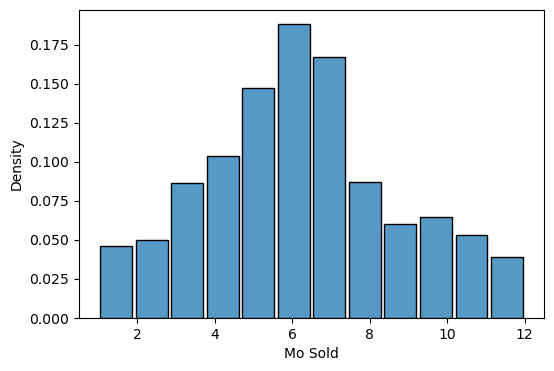

In [14]:
sns.histplot(data=df['Mo Sold'], stat='density', bins=12, shrink=0.9);

Looking at the distribution plot above, for now, we'll keep this feature.

### Dealing with skewed features

In [28]:
# Check the skewness of numerical features
numeric_df = df.select_dtypes(include=['number'])
skewed_features = numeric_df.apply(lambda x: stats.skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewness': skewed_features})
skewness.head(10)

,Skewness
Lot Area,13.177
3Ssn Porch,11.390
Kitchen AbvGr,4.308
Enclosed Porch,4.009
Screen Porch,3.952
Bsmt Half Bath,3.952
Mas Vnr Area,2.598
Open Porch SF,2.494
Wood Deck SF,1.844
MS SubClass,1.356


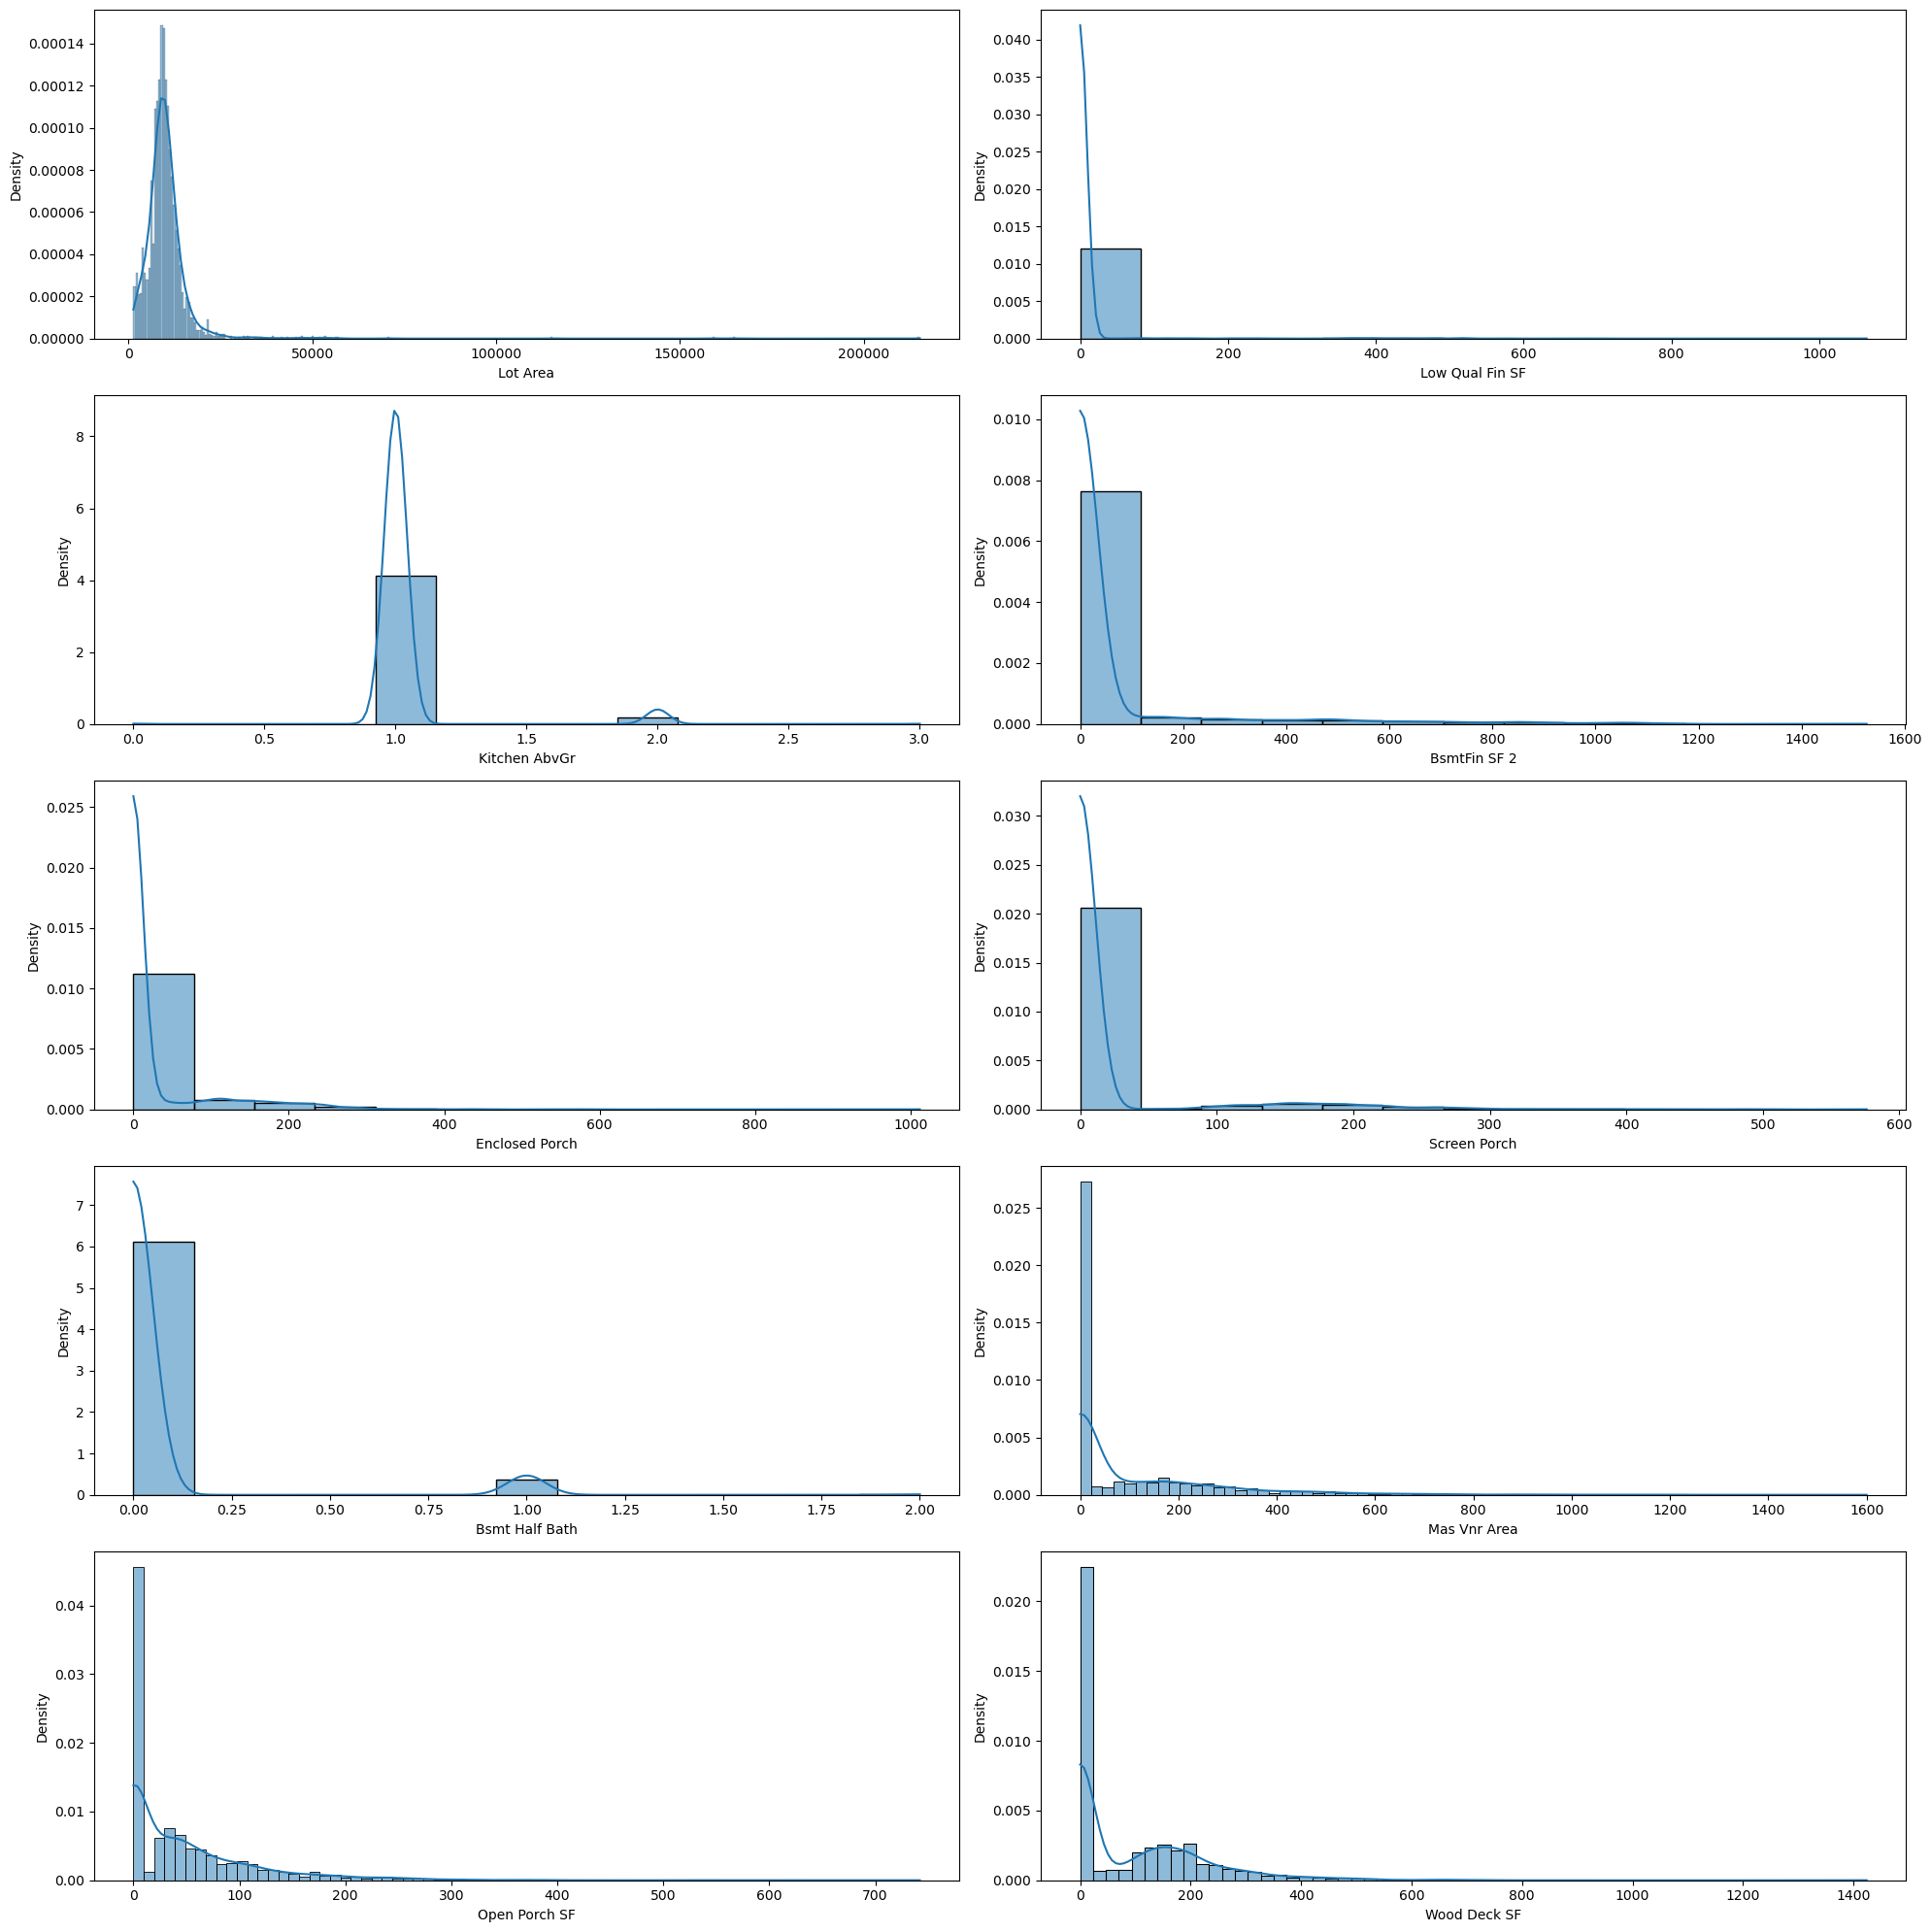

In [35]:
# Visualize distribution of features with high skewness
cols = skewness.index.tolist()[:10]

fig, axes = plt.subplots(5, 2, figsize=(15, 15))
axes = axes.ravel()
for col, ax in zip(cols, axes):
    sns.histplot(data=df[col], kde=True, stat='density', ax=ax)
fig.tight_layout()
plt.show()

Box Cox transformation of highly skewed features, using boxcox1p since the data contains 0

In [29]:
# set lambda to 0.15
skewness = skewness[abs(skewness) > 1]
skewed_features = skewness.index.tolist()
for feature in skewed_features:
    df[feature] = boxcox1p(df[feature], 0.15)
    
print("There are {} skewed numerical features to were BoxCox transformed.".format(skewness.shape[0]))

There are 31 skewed numerical features to were BoxCox transformed.


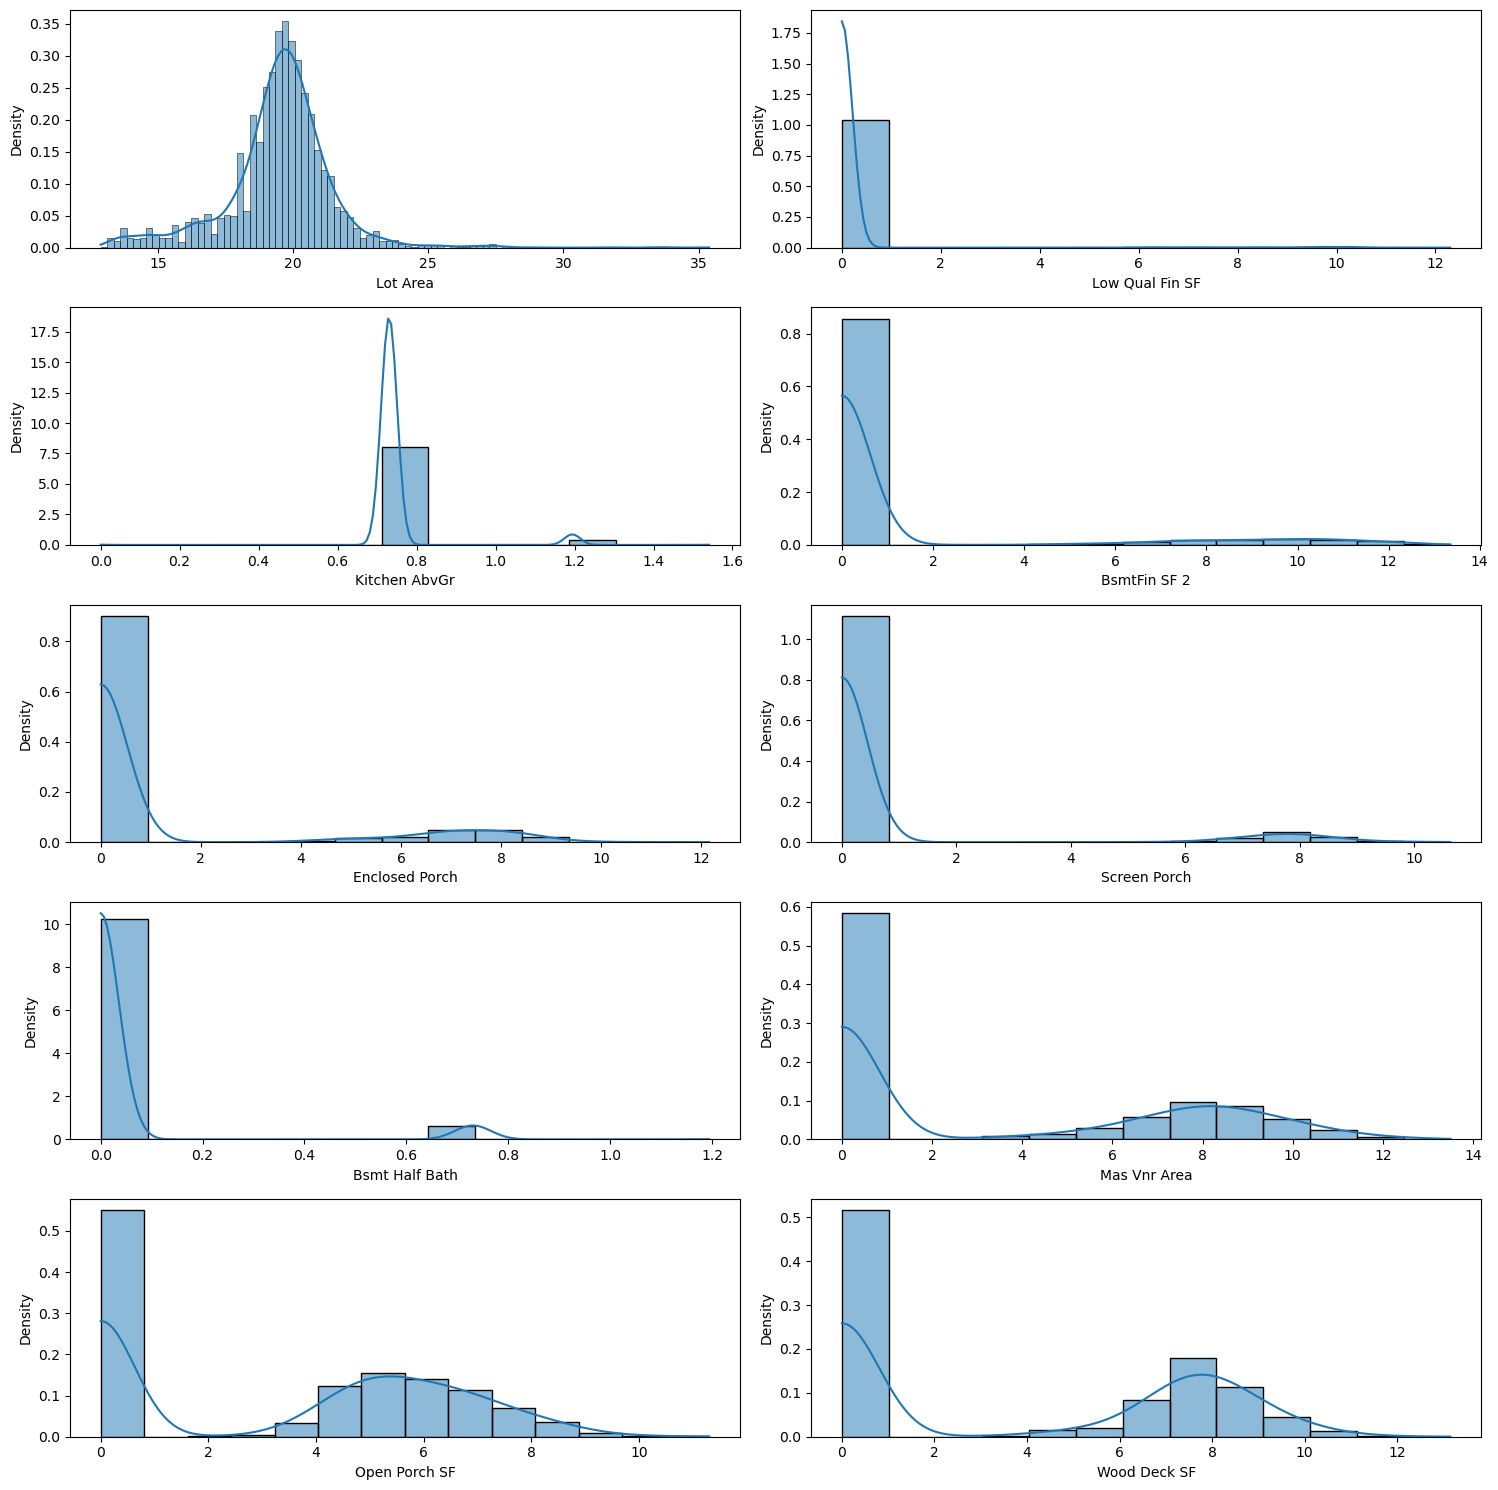

In [40]:
# Plot the distribution after Box Cox transformation
fig, axes = plt.subplots(5, 2, figsize=(15, 15))
axes = axes.ravel()
for col, ax in zip(cols, axes):
    sns.histplot(data=df[col], kde=True, stat='density', ax=ax)
fig.tight_layout()
plt.show()

<h1 style="font-size: 1.8em; background-color: #CFB87C; padding: 0.8em">Feature Encoding</h1>

First, we will divide categorical features into nominal and ordinal since different encoding method will be applied to them.

Some categorical features in our data are ordinal in nature, i.e. there is a natural ordering inherent. For example:

| Feature | 4 | 3 | 2 | 1 |
| --- | --- | --- | --- | --- |
|ExterQual | Excellent | Good | Average | Fair Poor |

Therefore, this type of feature will be encoded as an integer array.

Information on which nominal or ordinal features was given in data documentation:
https://jse.amstat.org/v19n3/decock/DataDocumentation.txt

In [30]:
categorical_features = df.select_dtypes(exclude=['number']).columns.tolist()

In [31]:
nominal = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config', 
           'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 
           'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 
           'Central Air', 'Garage Type', 'Sale Type', 'Sale Condition']

In [32]:
ordinal = [x for x in categorical_features if x not in nominal]
print(ordinal)

['Lot Shape', 'Land Slope', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Fence']


Next, we will to encode nominal features with one hot encoding, and ordinal features with encode_ordinals from Sklearn

### One hot encoding nominal features

In [33]:
df_nominal_encoded = pd.get_dummies(df[nominal], drop_first=True)

### Encoding ordinal features

In [34]:
encoder = OrdinalEncoder()
df_ordinal_encoded = encoder.fit_transform(df[ordinal])
df_ordinal_encoded = pd.DataFrame(df_ordinal_encoded, columns=df[ordinal].columns)

### Combine nominal and ordinal features

In [35]:
df_categorical_encoded = pd.concat([df_nominal_encoded, df_ordinal_encoded], axis=1)

### Combine numerical and categorical features

In [36]:
df_numerical = df.select_dtypes(include='number').drop('SalePrice', axis=1)
df_features_encoded = pd.concat([df_numerical, df_categorical_encoded], axis=1)

## Skip cleaning process for testing models

In [56]:
df_cleaned_encoded = df_features_encoded
df_cleaned_encoded['SalePrice'] = df['SalePrice']

In [57]:
df_cleaned_encoded.to_csv('df_cleaned_encoded.csv', index=False)

In [3]:
df_features_encoded = pd.read_csv('df_cleaned_encoded.csv')

In [4]:
y = df_features_encoded['SalePrice']
df_features_encoded = df_features_encoded.drop('SalePrice', axis=1)

<h1 style="font-size: 1.8em; background-color: #CFB87C; padding: 0.8em">Modelling</h1>

In [37]:
X = df_features_encoded
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [39]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
# Reference: https://stackoverflow.com/questions/69432869/rmse-cross-validation-using-sklearn
def rmse_cv(regressor):
    scores = cross_val_score(regressor, X_train_scaled, y_train, scoring='neg_mean_squared_error',
                            cv=5, n_jobs=-1)
    rmse = np.sqrt(np.mean(np.abs(scores)))
    return rmse

<h1 style="font-size: 1.4em; background-color: #A2A4A3; padding: 0.8em">Lasso</h1>

We will use Sklearn's LassoCV to find the optimal alpha for us. LassoCV will find alphas along the regularization path.

In [208]:
lasso = LassoCV(random_state=0, cv=10, n_jobs=-1)
lasso.fit(X_train_scaled, y_train)

LassoCV(cv=10, n_jobs=-1, random_state=0)

In [209]:
rmse_cv(lasso)

0.014079272206150174

In [222]:
alpha_opt = lasso.alpha_
alpha_opt

5.6816408852194104e-05

In [211]:
# Coefficient of determination (R2)
lasso.score(X_test_scaled, y_test)

0.9255800610261592

<h1 style="font-size: 1.4em; background-color: #A2A4A3; padding: 0.8em">Ridge</h1>

In [220]:
from sklearn.linear_model import ElasticNet

In [221]:
ENet = ElasticNet(alpha=alpha_opt, l1_ratio=0.5, random_state=0)
ENet.fit(X_train_scaled, y_train)

ElasticNet(alpha=5.6816408852194104e-05, random_state=0)

In [32]:
rmse_cv(ENet)

0.01415966040607238

In [33]:
ENet.score(X_test_scaled, y_test)

0.9272735631358577

In [212]:
ridge = RidgeCV()
ridge.fit(X_train_scaled, y_train)

RidgeCV()

In [213]:
ridge.score(X_test_scaled, y_test)

0.9293540727992273

<h1 style="font-size: 1.4em; background-color: #A2A4A3; padding: 0.8em">Random Forest</h1>

In [49]:
rf = RandomForestRegressor(n_estimators=1000, max_features='sqrt', random_state=0)
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=1000, random_state=0)

In [42]:
# Coefficient of determination (R2)
rf.score(X_test_scaled, y_test)

0.9110366558790735

<h1 style="font-size: 1.4em; background-color: #A2A4A3; padding: 0.8em">Gradient Boosting</h1>

Reference:

https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

### Hyperparameter tuning

There's a trade off between learning_rate and n_estimators. As the base parameter, we will use GridSearchCV to select best combination of learning_rate and n_estimators.

In [175]:
params = {
    'learning_rate': [0.01, 0.02, 0.03],
    'n_estimators': [3000, 4000, 5000, 6000]
}
start_time = time.time()
gboost = GridSearchCV(GradientBoostingRegressor(random_state=0), param_grid=params, n_jobs=-1)
gboost.fit(X_train_scaled, y_train)
elapsed_time = (time.time() - start_time)/60
print('GridSearchCV evaluation in {:.2f} minutes'.format(elapsed_time))

GridSearchCV evaluation in 19.16 minutes


In [176]:
gboost.best_params_

{'learning_rate': 0.01, 'n_estimators': 5000}

In [177]:
gboost.best_score_

0.9023722621816059

In [178]:
loss_func = ['squared_error', 'absolute_error', 'huber']
train_results = []
test_results = []

for ls in loss_func:
    model = GradientBoostingRegressor(loss=ls, n_estimators=5000, learning_rate=0.01, random_state=0)
    model.fit(X_train_scaled, y_train)
    score = model.score(X_train_scaled, y_train)
    train_results.append(score)
    score = model.score(X_test_scaled, y_test)
    test_results.append(score)

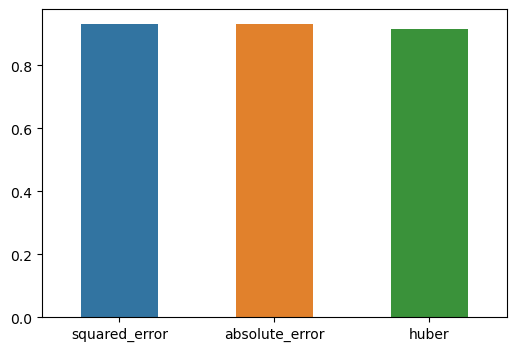

In [184]:
sns.barplot(x=loss_func, y=test_results, width=0.5);

The different loss functions are actually quite comparable in performance.

In [139]:
max_feats = ['sqrt', 'log2', None]
train_results = []
test_results = []

for maxFeat in max_feats:
    model = GradientBoostingRegressor(max_features=maxFeat, loss='absolute_error', n_estimators=5000,
                                      learning_rate=0.01, random_state=0)
    model.fit(X_train_scaled, y_train)
    score = model.score(X_train_scaled, y_train)
    train_results.append(score)
    score = model.score(X_test_scaled, y_test)
    test_results.append(score)

In [141]:
test_results

[0.936272373736345, 0.9338366991857215, 0.9304931648180275]

max_features 'sqrt' is optimal

In [146]:
maxDepths = [2, 3, 4, 5]
train_results = []
test_results = []

for maxDepth in maxDepths:
    model = GradientBoostingRegressor(max_depth=maxDepth, n_estimators=5000, learning_rate=0.01, max_features='sqrt',
                                     min_samples_leaf=10, min_samples_split=10, loss='huber', random_state=0)
    model.fit(X_train_scaled, y_train)
    score = model.score(X_train_scaled, y_train)
    train_results.append(score)
    score = model.score(X_test_scaled, y_test)
    test_results.append(score)

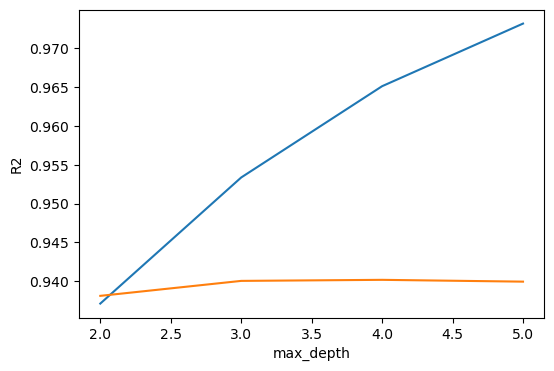

In [147]:
plt.plot(maxDepths, train_results, label='train')
plt.plot(maxDepths, test_results, label='test')
plt.xlabel('max_depth')
plt.ylabel('R2');

max_depth = 4 is optimal

In [149]:
test_results

[0.9381176630651594, 0.940043827861903, 0.9401790769611951, 0.9399468645536864]

#### Best model for GradientBoostingRegressor

In [215]:
gboost = GradientBoostingRegressor(n_estimators=6000, learning_rate=0.01,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=0)
gboost.fit(X_train_scaled, y_train)

GradientBoostingRegressor(learning_rate=0.01, loss='huber', max_depth=4,
                          max_features='sqrt', min_samples_leaf=15,
                          min_samples_split=10, n_estimators=6000,
                          random_state=0)

In [169]:
rmse_cv(gboost)

0.013922643166718231

In [170]:
# Coefficient of determination (R2)
gboost.score(X_test_scaled, y_test)

0.940592353871252

<h1 style="font-size: 1.4em; background-color: #A2A4A3; padding: 0.8em">XGBoost</h1>

Reference:

https://xgboost.readthedocs.io/en/release_0.82/parameter.html

#### Hyperparameter tuning

In [201]:
xgboost = xgb.XGBRegressor(n_estimators=1000, max_depth=2, learning_rate=0.1, random_state=0)
xgboost.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [60]:
# Coefficient of determination (R2)
xgboost.score(X_test_scaled, y_test)

0.9299580770406588

In [249]:
rmse_cv(xgboost)

0.014311645783708074

<h1 style="font-size: 1.8em; background-color: #A2A4A3; padding: 0.8em">Stacking Regressor</h1>

Reference:

https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py

Stacking Regressor is a technique that takes several regression models and uses their output as the input for the meta-regressor (final_estimator).

In [250]:
estimators = [
    ('Ridge', ridge),
    ('Gradient Boost', gboost),
    ('Random Forest', rf)
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=lasso)
start_time = time.time()
stacking_regressor.fit(X_train_scaled, y_train)
elapsed_time = (time.time() - start_time)/60
print('Stacking Regressor fitted in {:.2f} minutes'.format(elapsed_time))

Stacking Regressor fitted in 7.11 minutes


In [254]:
stacking_regressor

StackingRegressor(estimators=[('Ridge', RidgeCV()),
                              ('Gradient Boost',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         loss='huber',
                                                         max_depth=4,
                                                         max_features='sqrt',
                                                         min_samples_leaf=15,
                                                         min_samples_split=10,
                                                         n_estimators=6000,
                                                         random_state=0)),
                              ('Random Forest',
                               RandomForestRegressor(max_depth=15,
                                                     max_features=None,
                                                     min_samples_leaf=5,
                                                     min_samples_split=5,
                                                     n_estimators=1200,
                                                     oob_score=True,
                                                     random_state=42))],
                  final_estimator=LassoCV(cv=10, n_jobs=-1, random_state=0))

In [251]:
stacking_regressor.score(X_test_scaled, y_test)   #best score so far

0.9413080596317711

In [253]:
rmse_cv(stacking_regressor)

0.01350370235786859

In [244]:
estimators = [
    ('Ridge', ridge),
    ('Gradient Boosting', gboost),
    ('XGBoost', xgboost),
]
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=lasso)
start_time = time.time()
stacking_regressor.fit(X_train_scaled, y_train)
elapsed_time = (time.time() - start_time)/60
print('Stacking Regressor fitted in {:.2f} minutes'.format(elapsed_time))

Stacking Regressor fitted in 3.35 minutes


In [246]:
stacking_regressor

StackingRegressor(estimators=[('Ridge', RidgeCV()),
                              ('Gradient Boosting',
                               GradientBoostingRegressor(learning_rate=0.01,
                                                         loss='huber',
                                                         max_depth=4,
                                                         max_features='sqrt',
                                                         min_samples_leaf=15,
                                                         min_samples_split=10,
                                                         n_estimators=6000,
                                                         random_state=0)),
                              ('XGBoost',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            c...
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=2,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=0, ...))],
                  final_estimator=LassoCV(cv=10, n_jobs=-1, random_state=0))

In [245]:
stacking_regressor.score(X_test_scaled, y_test)

0.9411600174454463

In [248]:
rmse_cv(stacking_regressor)

0.013499116701965255

<h1 style="font-size: 1.8em; background-color: #CFB87C; padding: 0.8em">Conclusion</h1>

Reference:

https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py

## DO NOT RUN THE CELL BELOW !!!!

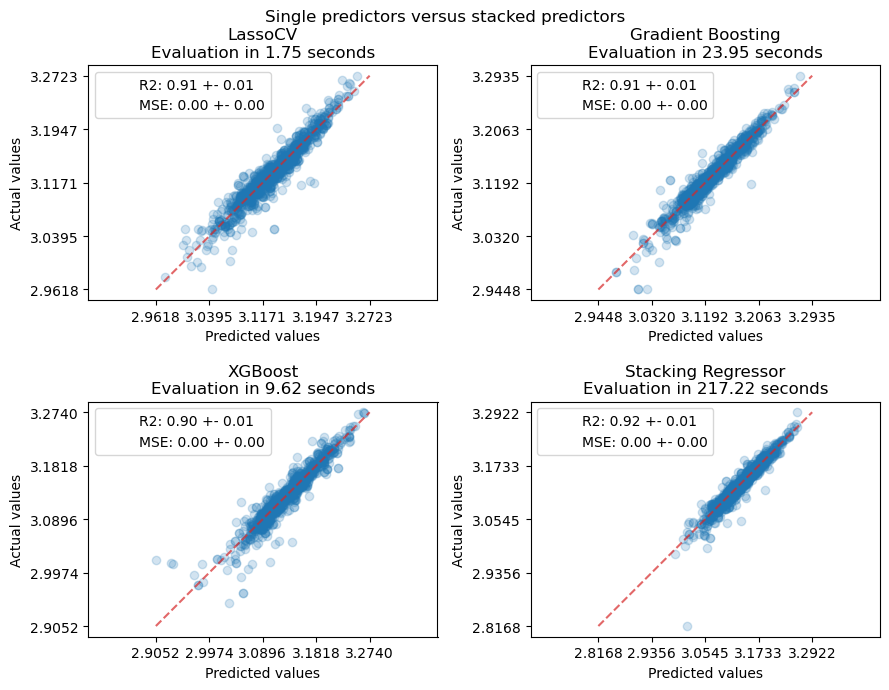

In [87]:
from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    scorers = {"R2": "r2", "MSE": "neg_mean_squared_error"}

    start_time = time.time()
    scores = cross_validate(
        est, X, y, scoring=list(scorers.values()), n_jobs=-1, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)
    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.3f} +- "
            f"{np.std(scores[f'test_{value}']):.3f}"
        )
        for key, value in scorers.items()
    }

    display = PredictionErrorDisplay.from_predictions(
        y_true=y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")

plt.suptitle("Single predictors versus stacked predictors\n")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

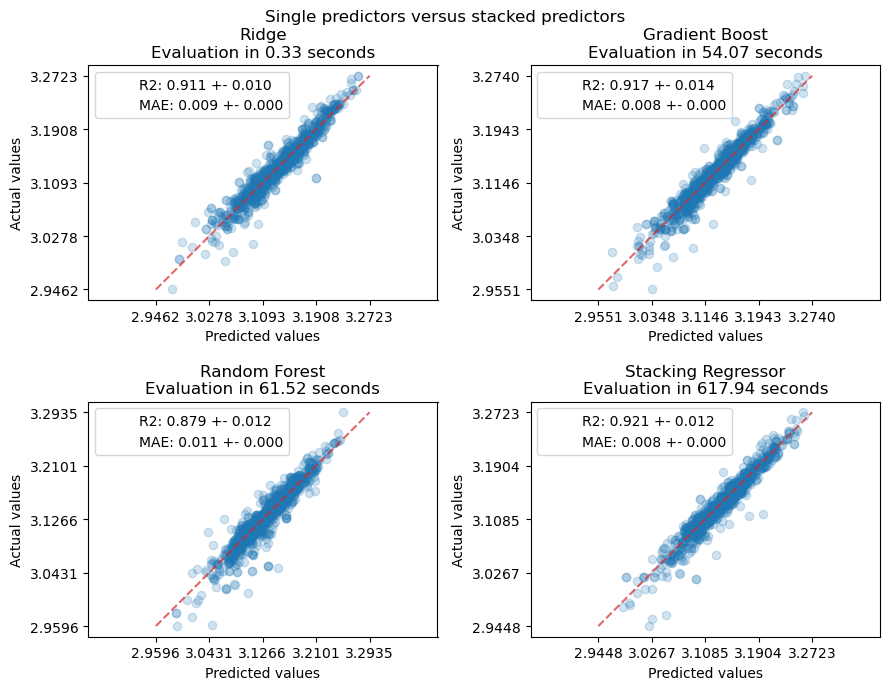

In [255]:
fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    scorers = {"R2": "r2", "MAE": "neg_mean_absolute_error"}

    start_time = time.time()
    scores = cross_validate(
        est, X, y, scoring=list(scorers.values()), n_jobs=-1, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)
    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.3f} +- "
            f"{np.std(scores[f'test_{value}']):.3f}"
        )
        for key, value in scorers.items()
    }

    display = PredictionErrorDisplay.from_predictions(
        y_true=y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")

plt.suptitle("Single predictors versus stacked predictors\n")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

The stacked regressor will combine the strengths of the different regressors. However, we also see that training the stacked regressor is much more computationally expensive.

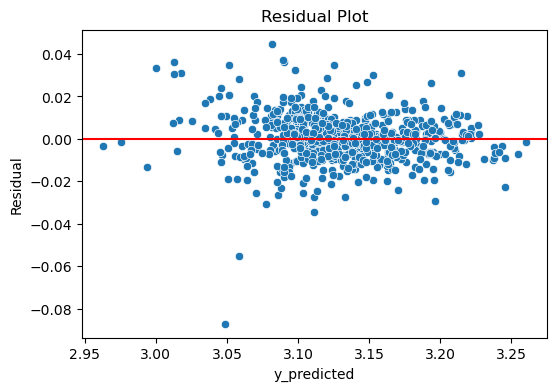

In [256]:
stacking_regressor_preds = stacking_regressor.predict(X_test_scaled)
resid = y_test - stacking_regressor_preds
df_resid = pd.DataFrame({'y_predicted': stacking_regressor_preds, 'Residual': resid})
ax = sns.scatterplot(data=df_resid, x='y_predicted', y='Residual')
ax.axhline(y=0, c='red')
plt.title('Residual Plot');

There is no definite pattern (something like linear or quadratic or funnel shaped) in the Residual plot. It seems that there is no violation of homoscedasticity or autocorrelation

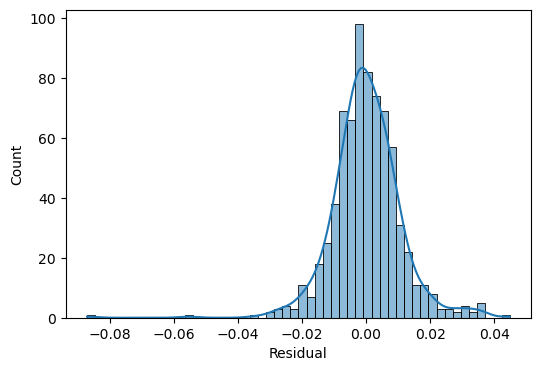

In [258]:
sns.histplot(df_resid['Residual'],kde=True);

No violation of the normality assumption on the error term/residuals.